# Deadlines aus Simulation (FIFO)

In [1]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

from src.utils.production_process import initialize as init

# Extern
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
pd.set_option('display.min_rows', 21)
pd.set_option('display.max_rows', 25)

In [2]:
import src.utils.figurator as fig_gen

In [3]:
basic_data_path = get_path("data", "basic")
day_count = 360
day_count = 600

df_jobs_times = pd.read_csv(basic_data_path / f"jobs_times_{day_count}_raw.csv")
df_jobs_times

,Job,Production_Plan_ID,Arrival,Ready Time,End,Processing Time
0,0,0,51,1440,3050.0,395
1,1,1,136,1440,2736.0,510
2,2,2,158,1440,2258.0,568
3,3,3,236,1440,2926.0,655
4,4,4,404,1440,3007.0,393
5,5,5,485,1440,2731.0,496
6,6,6,501,1440,2646.0,416
7,7,7,528,1440,3085.0,539
8,8,8,550,1440,2985.0,597
9,9,9,559,1440,2970.0,540


## II) Log-Normalverteilung

Für jede Gruppe in der Spalte `Production_Plan_ID` wird die Deadline multiplikativ gestreut:

$$
Deadline_i = E_i \cdot R_i,\quad R_i \sim \mathrm{LogNormal}(\mu, \sigma)
$$

- method = 'mean': $\mathbb{E}[R_i] = 1 \Longrightarrow \mu = -\frac{\sigma^2}{2}$

- method = 'mode': $\mathrm{mode}\,R_i = 1 \Longrightarrow \mu = \sigma^2$

---

- **$E_i$**: Ursprünglicher End-Zeitpunkt für Job i

- **$Deadline_i$**: Neue lognormal gestreute Deadline für Job i

- **$R_i$**: Zufallsfaktor, definiert als $R_i = \frac{Deadline_i}{E_i}$

- **σ (sigma)**: Standardabweichung der Lognormal-Verteilung

- **μ (mu)**: Lageparameter der Lognormal-Verteilung, gewählt über method

In [4]:
import numpy as np
import pandas as pd

def add_groupwise_lognormal_deadlines_multiplicative(df: pd.DataFrame, sigma: float = 0.2, seed: int = 42, method: str = 'mean') -> pd.DataFrame:
    """
    Erzeugt für jede Gruppe in 'Production_Plan_ID' eine lognormal-verteilte Deadline.

    Deadline_i = End_i * R_i, wobei R_i ~ LogNormal(μ, σ) ist.
    Bei method='mean' wird E[R_i]=1 (μ = –σ²/2),
    bei method='mode' mode(R_i)=1 (μ = +σ²).

    Parameters
    ----------
    df : pd.DataFrame
        Muss Spalten 'Production_Plan_ID' und 'End' enthalten.
    sigma : float, optional
        Standardabweichung der Log-Normal-Verteilung (Default 0.2).
    seed : int, optional
        Zufalls-Seed (Default 42).
    method : {'mean','mode'}, optional
        Lageparameter-Steuerung (Default 'mean').

    Returns
    -------
    pd.DataFrame
        Kopie von df mit neuer Spalte 'Deadline' (float, 1 Dezimalstelle).
    """
    np.random.seed(seed)
    df_out = df.copy()
    df_out['Deadline'] = np.nan

    for plan_id, grp in df_out.groupby('Production_Plan_ID'):
        if method == 'mean':
            mu = -0.5 * sigma**2
        elif method == 'mode':
            mu = sigma**2
        else:
            raise ValueError("method muss 'mean' oder 'mode' sein.")

        R = np.random.lognormal(mean=mu, sigma=sigma, size=len(grp))
        df_out.loc[grp.index, 'Deadline'] = np.round(grp['End'] * R, 1)

    return df_out


In [5]:
df_times = add_groupwise_lognormal_deadlines_multiplicative(df_jobs_times, sigma=0.2, method= "mean")
df_times

,Job,Production_Plan_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,0,0,51,1440,3050.0,395,3301.9
1,1,1,136,1440,2736.0,510,2400.7
2,2,2,158,1440,2258.0,568,2556.9
3,3,3,236,1440,2926.0,655,1872.2
4,4,4,404,1440,3007.0,393,3092.5
5,5,5,485,1440,2731.0,496,2664.6
6,6,6,501,1440,2646.0,416,2429.6
7,7,7,528,1440,3085.0,539,4217.9
8,8,8,550,1440,2985.0,597,3150.6
9,9,9,559,1440,2970.0,540,2614.2


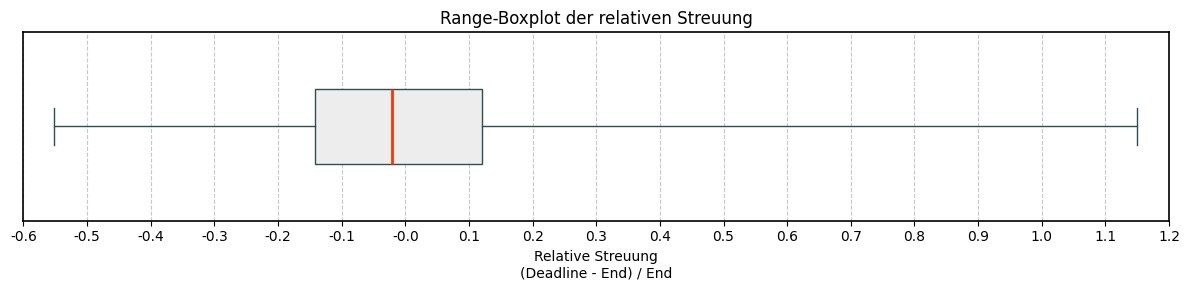

In [6]:
fig = fig_gen.plot_relative_spread_horizontal(df_times)
plt.show()  

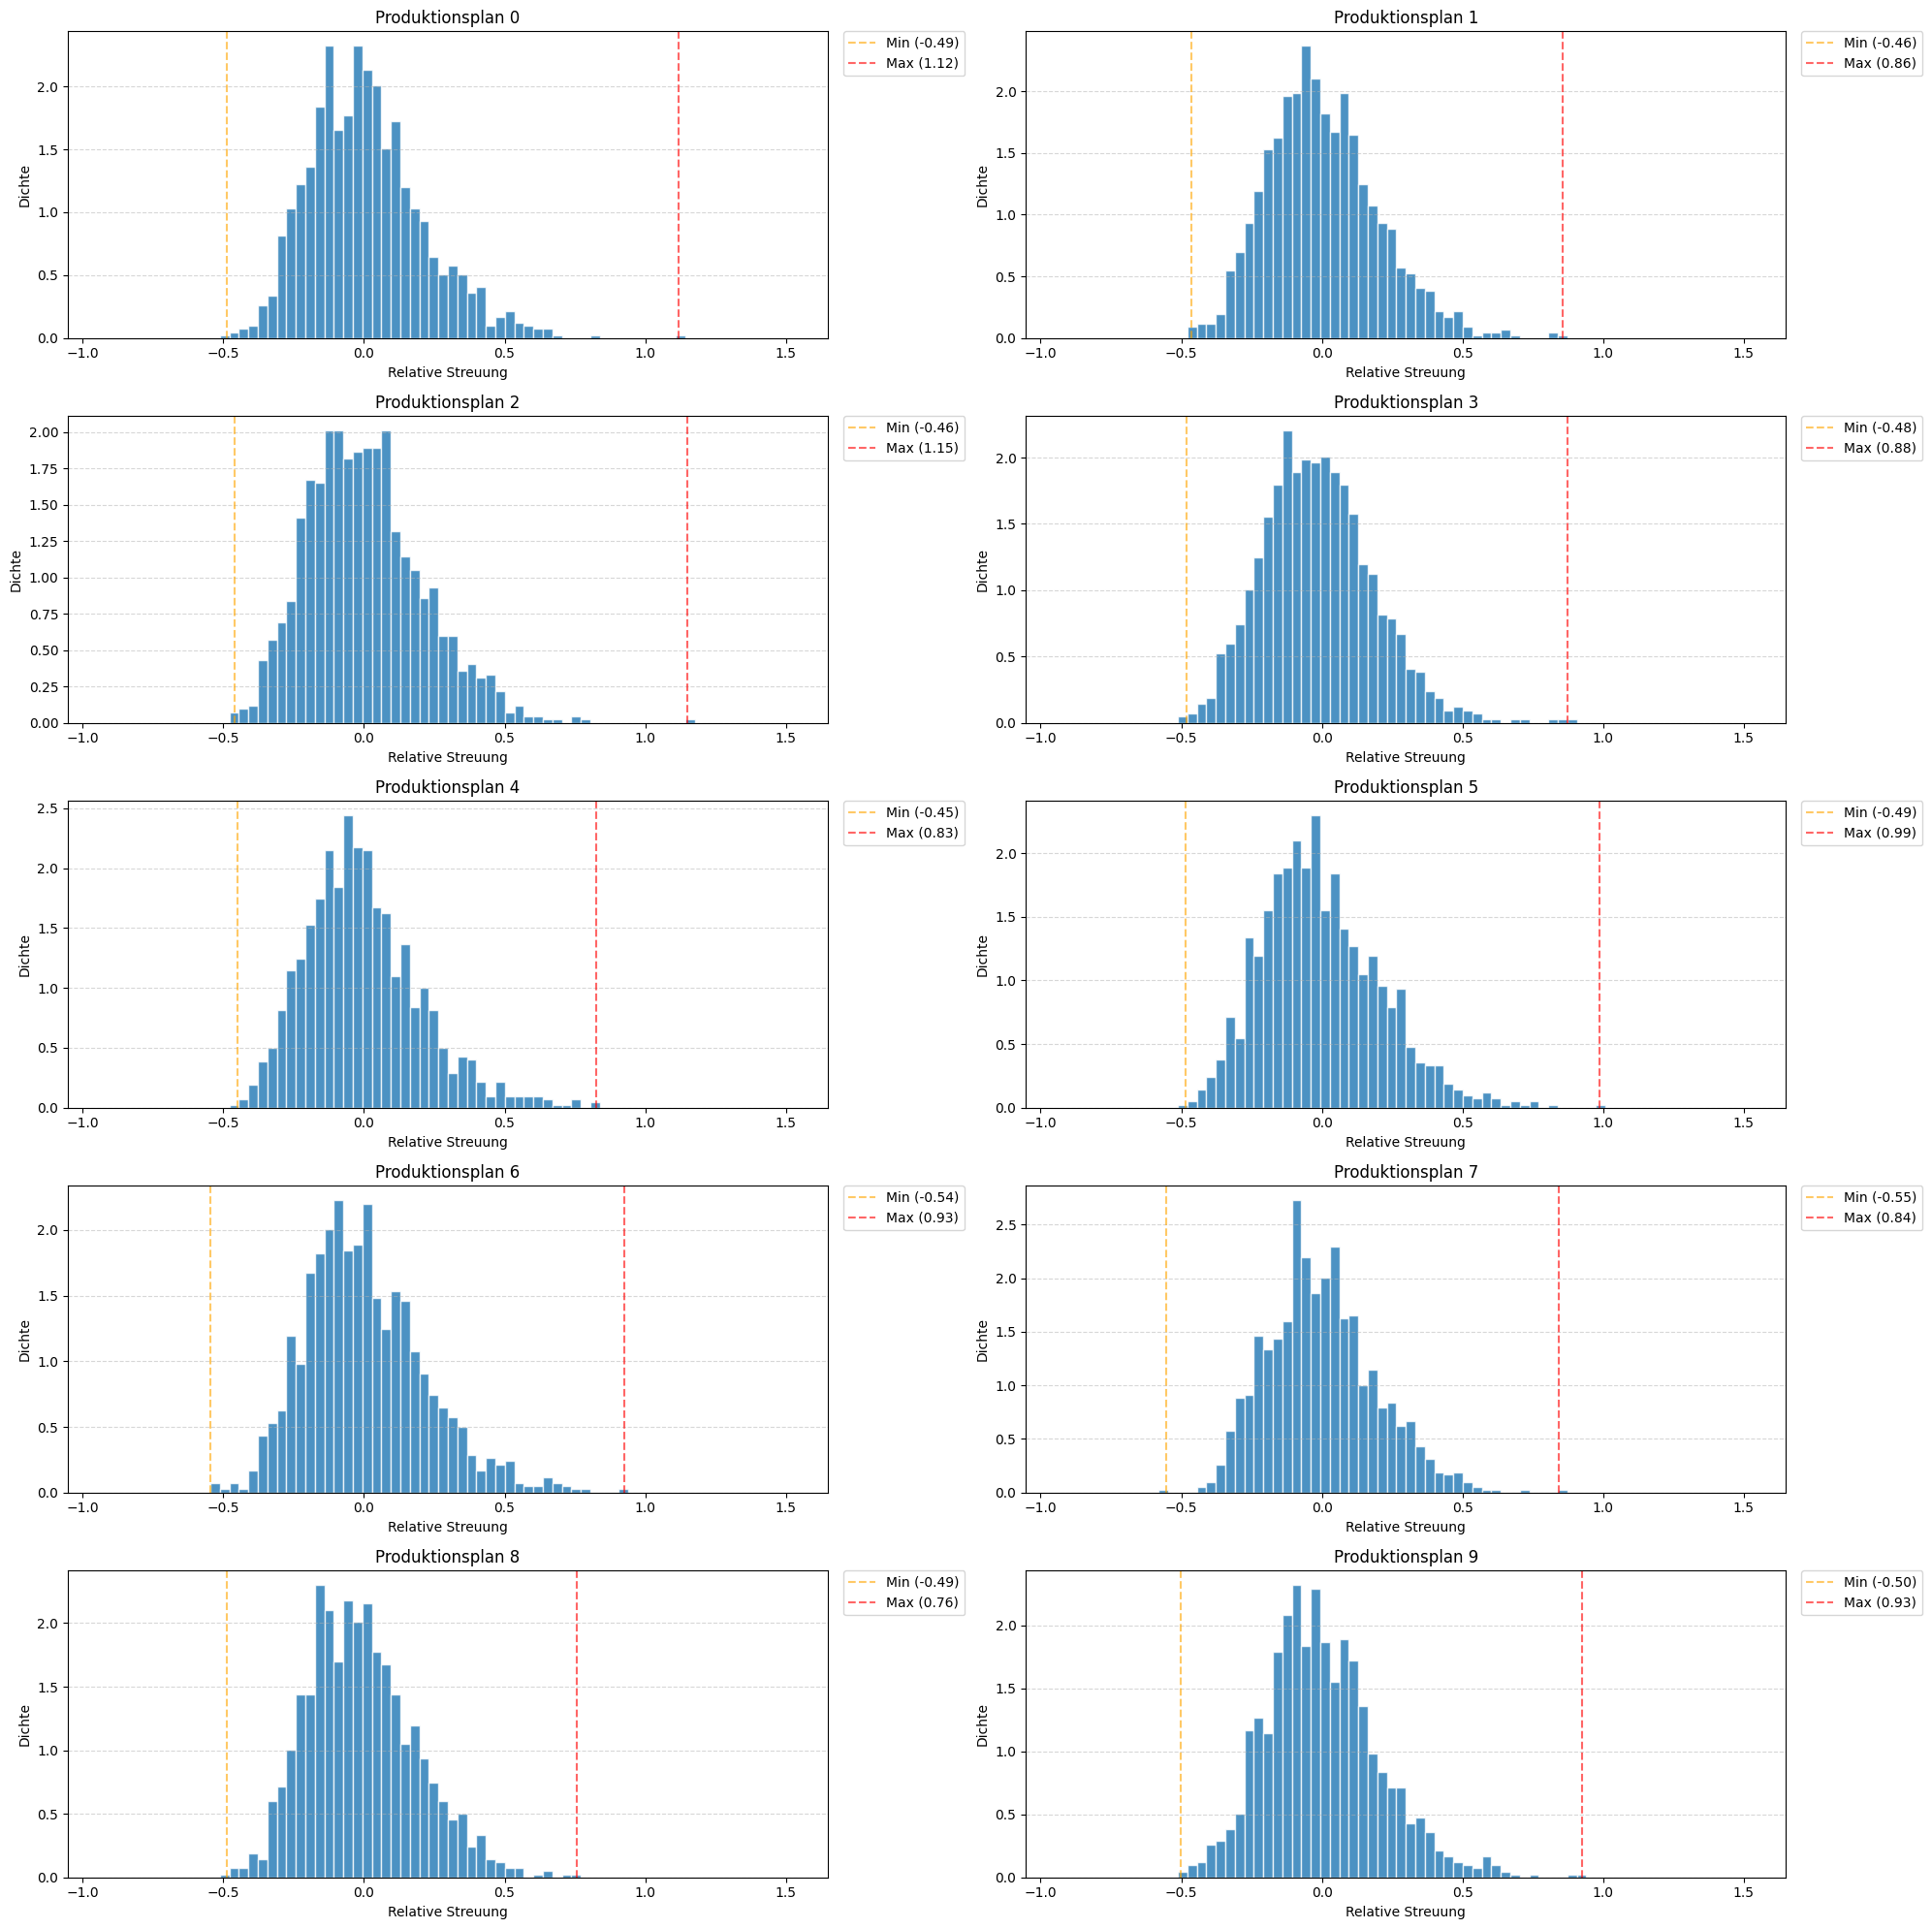

In [7]:
# Figure erzeugen (liefert ein Figure-Objekt mit allen Subplots)
fig = fig_gen.plot_relative_spread_histograms(df_times, max_cols=2)

# Speichern, z.B. als PNG
fig.savefig('produktionspläne_histogramme.png', dpi=300)

# Alle Plots gleichzeitig anzeigen
plt.show()

## III) "Untere Begrenzung" der Deadlines

In [8]:
df_times['Deadline'] = np.maximum(df_times['Deadline'],
                                  df_times['Ready Time'] 
                                  + df_times['Processing Time'] / 2
                                 )



df_times['Deadline'] = np.ceil(df_times['Deadline']).astype(int)
df_times

,Job,Production_Plan_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,0,0,51,1440,3050.0,395,3302
1,1,1,136,1440,2736.0,510,2401
2,2,2,158,1440,2258.0,568,2557
3,3,3,236,1440,2926.0,655,1873
4,4,4,404,1440,3007.0,393,3093
5,5,5,485,1440,2731.0,496,2665
6,6,6,501,1440,2646.0,416,2430
7,7,7,528,1440,3085.0,539,4218
8,8,8,550,1440,2985.0,597,3151
9,9,9,559,1440,2970.0,540,2615


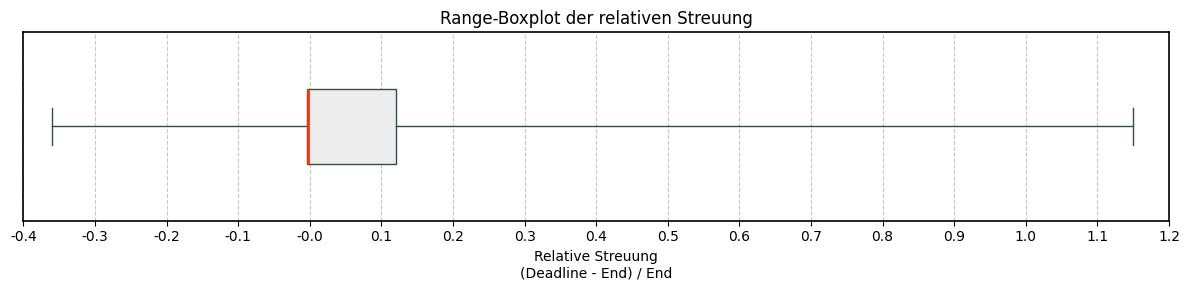

In [9]:
fig = fig_gen.plot_relative_spread_horizontal(df_times)
plt.show()   

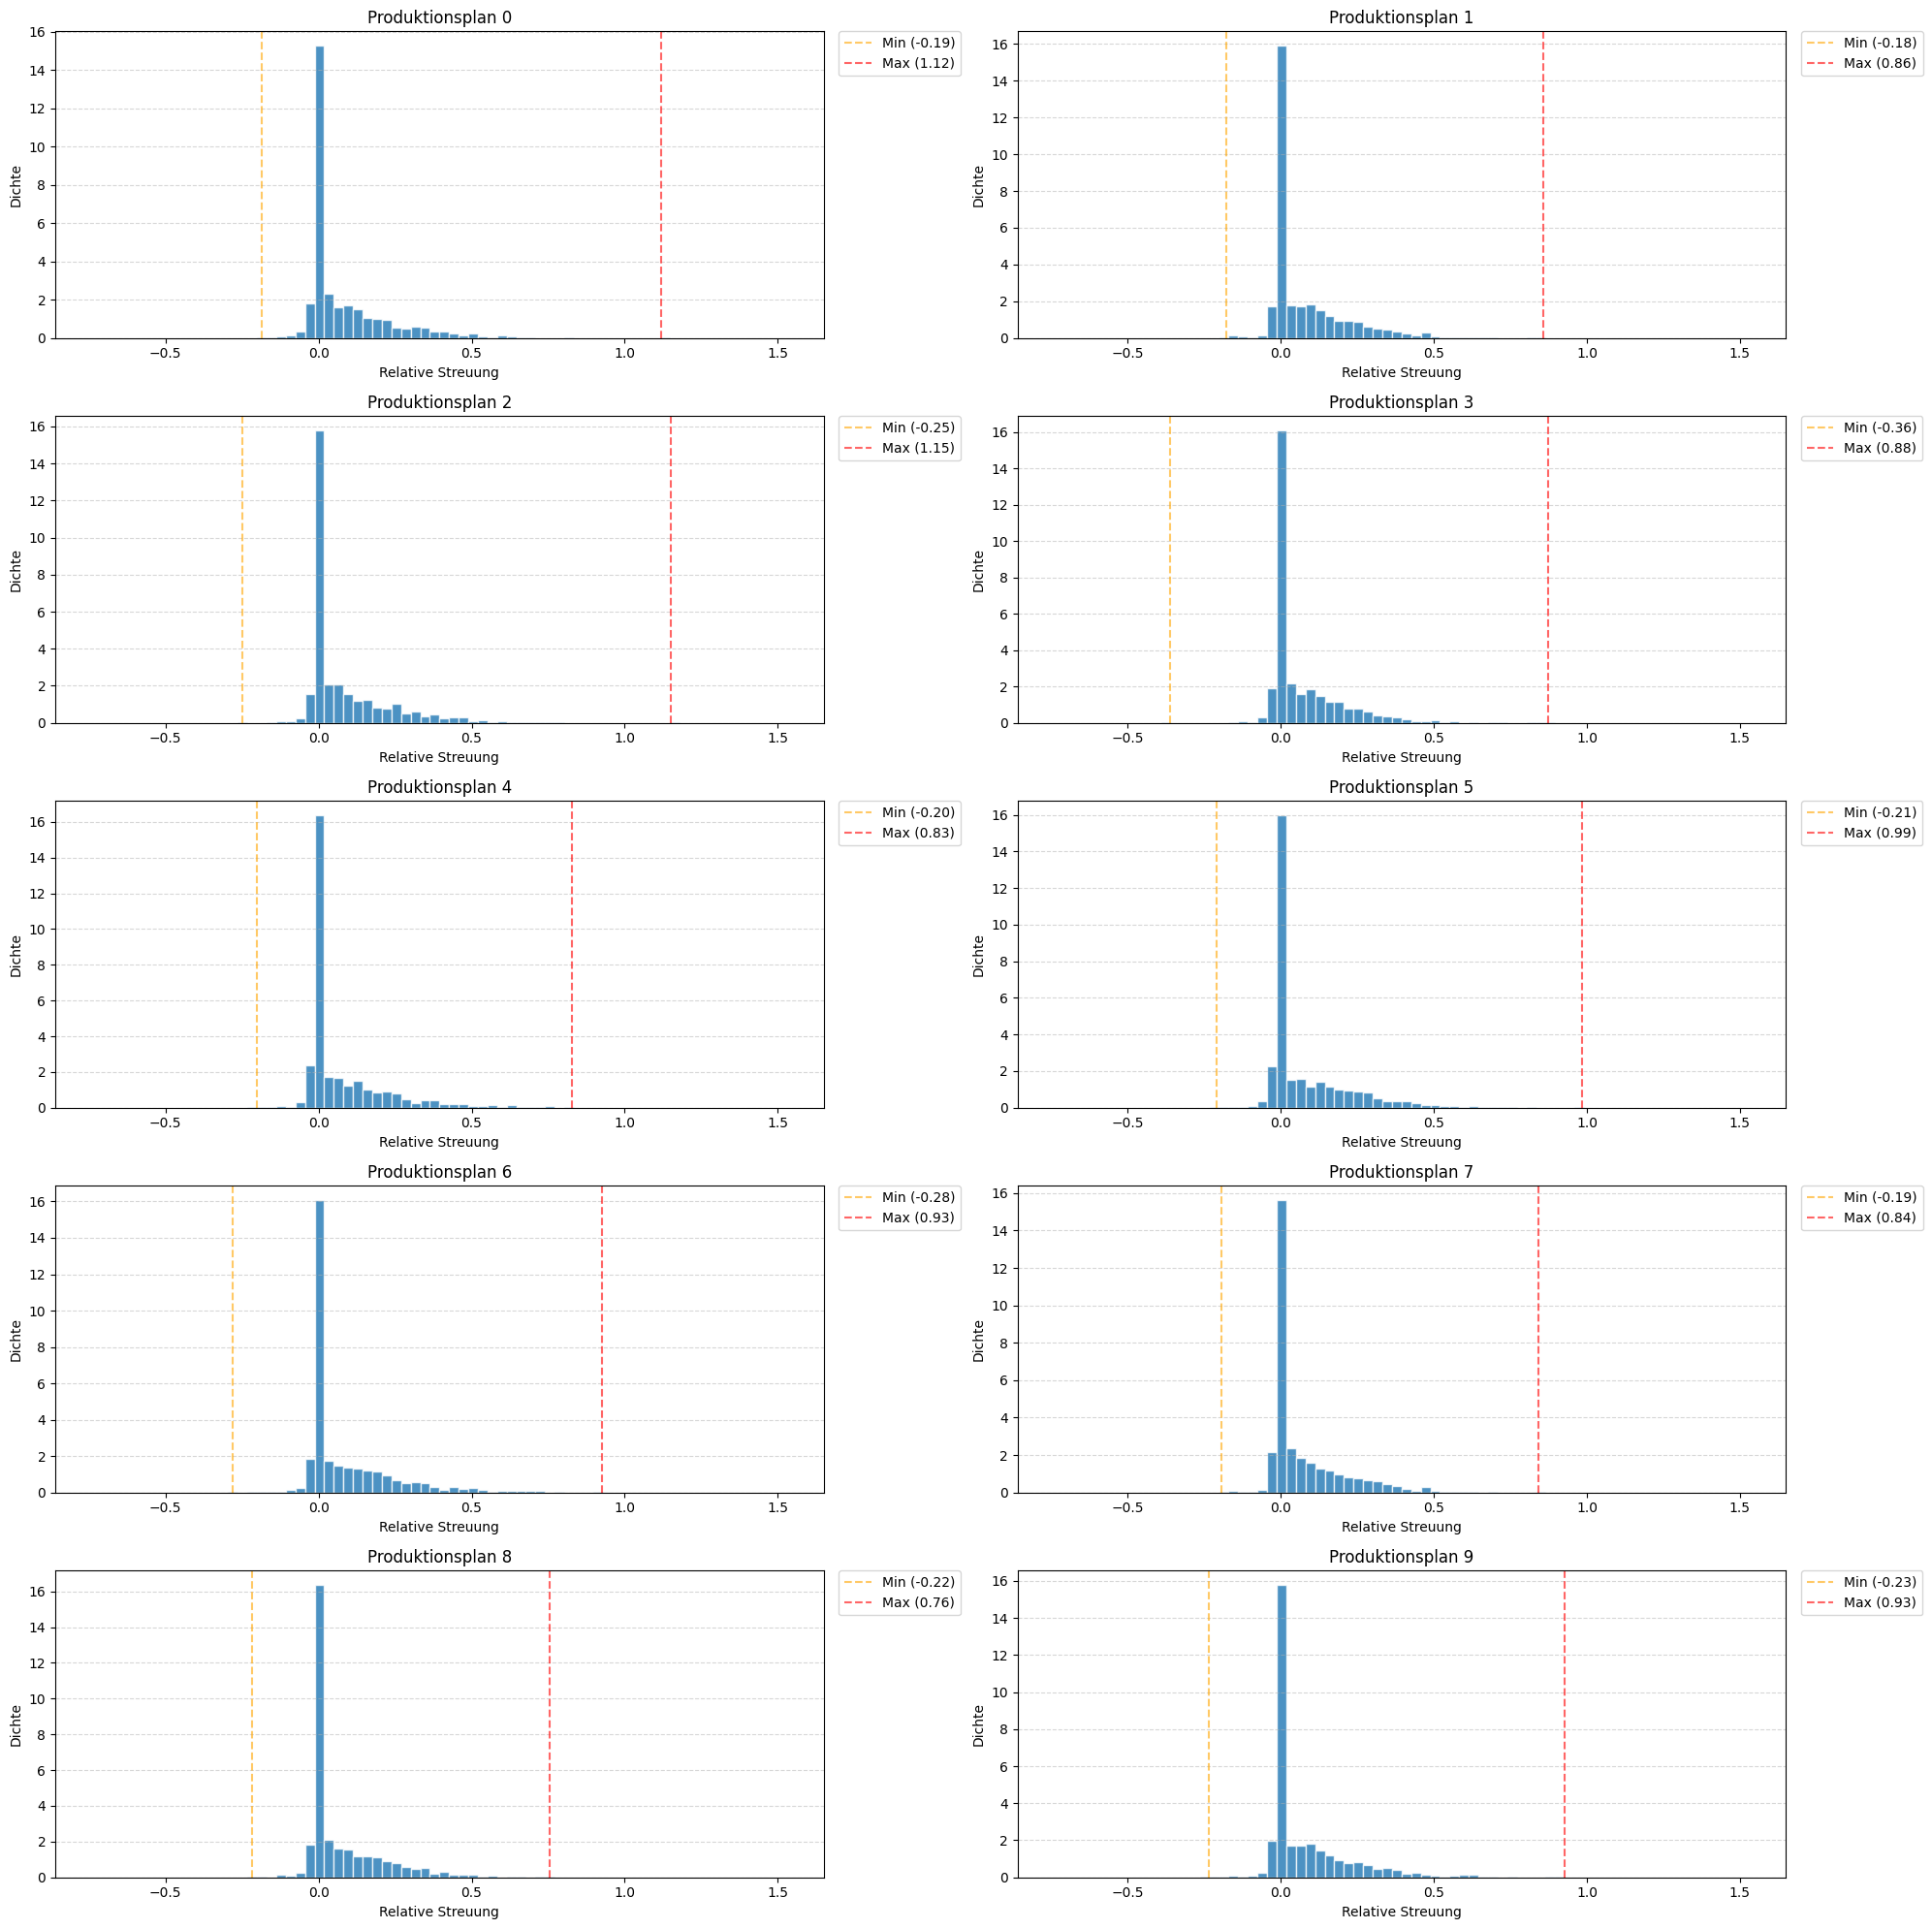

In [10]:
# Figure erzeugen (liefert ein Figure-Objekt mit allen Subplots)
fig = fig_gen.plot_relative_spread_histograms(df_times, max_cols=2)

# Speichern, z.B. als PNG
fig.savefig('produktionspläne_histogramme_gefiltert.png', dpi=300)

# Alle Plots gleichzeitig anzeigen
plt.show()

### Export

In [11]:
df_times.to_csv(basic_data_path / f"jobs_times_{day_count}_final.csv", index = False)